In [1]:
#Package needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.signal import firwin, freqz
from numpy import fft
from pylab import MaxNLocator    

In [2]:
#Simple function to convert unsigned number in signed
def convert_tosigned(x, nbits):
    if x >= 2**(nbits-1):
        x -= 2**nbits
    return x

FIR filter coefficients:  [0.03383324 0.24012702 0.45207947 0.24012702 0.03383324]


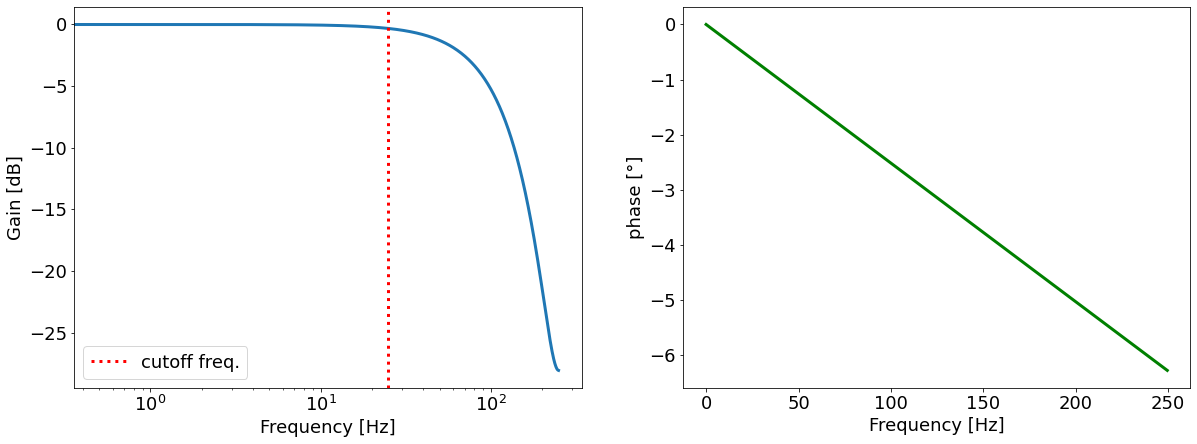

In [3]:
taps = 5
fcut = 0.1
coeff = np.asarray(firwin(taps, fcut ))
print("FIR filter coefficients: ", coeff)

f, h = freqz(coeff, fs = 500)
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 7))
ax1.plot(f, 20*np.log10(abs(h)), lw = 3)
angles = np.unwrap(np.angle(h))
ax2.plot(f, angles, color = 'green', lw = 3)

ax1.set_xlabel('Frequency [Hz]', fontsize = 18)
ax1.set_ylabel('Gain [dB]', fontsize = 18)
ax1.set_xscale('log')
ax1.axvline(x=25, color = 'red', ls = 'dotted', lw = 3, label = 'cutoff freq.')
ax1.legend(fontsize = 18)

ax2.set_xlabel('Frequency [Hz]', fontsize = 18)
ax2.set_ylabel('phase [°]', fontsize = 18)


ax1.tick_params(labelsize=18)
ax2.tick_params(labelsize=18)

plt.show()

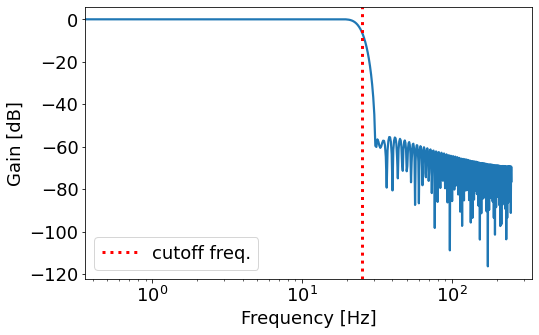

In [4]:
n_taps = 150
fcut = 0.1
coeff_150 = np.asarray(firwin(n_taps, fcut ))

f, h = freqz(coeff_150, fs = 500)
fig, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 5))
ax1.plot(f, 20*np.log10(abs(h)), lw = 2.2)

ax1.set_xlabel('Frequency [Hz]', fontsize = 18)
ax1.set_ylabel('Gain [dB]', fontsize = 18)
ax1.set_xscale('log')
ax1.axvline(x=25, color = 'red', ls = 'dotted', lw = 3, label = 'cutoff freq.')
ax1.legend(fontsize = 18)

ax1.tick_params(labelsize=18)

plt.show()

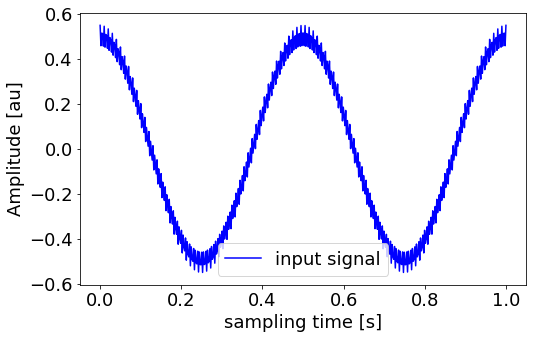

In [5]:
#Defining a noisy input signal
freq = 2
nf = 500
sampling = np.linspace(0, 1, nf)
freq_noise = 200
sig_no_noise = 0.5*np.cos(2*np.pi*freq*sampling)
noise = 0.05 * np.cos(2*np.pi*freq_noise*sampling)
sig = sig_no_noise + noise
plt.figure(figsize = (8, 5))
plt.plot(sampling, sig, label='input signal', c='blue')
plt.xlabel('sampling time [s]', fontsize = 18)
plt.legend(fontsize = 18)
plt.ylabel('Amplitude [au]', fontsize = 18)
plt.tick_params(labelsize=18)
plt.show()

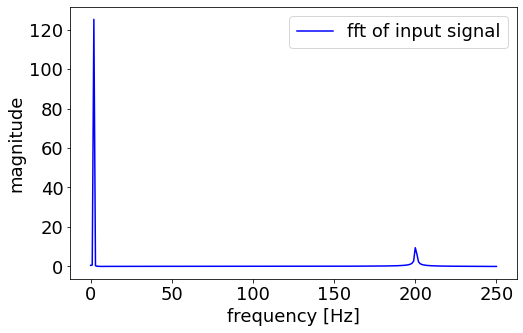

In [6]:
spectrum_sampl = fft.rfft(sig, nf)
freq_fourier = fft.rfftfreq(nf, d=1/nf)
plt.figure(figsize = (8, 5))
plt.xlabel('frequency [Hz]', fontsize = 18)
plt.ylabel('magnitude', fontsize = 18)
plt.plot(freq_fourier, np.abs(spectrum_sampl), label='fft of input signal', c='blue')
plt.legend(fontsize = 18)
plt.tick_params(labelsize=18)
plt.show()

In [7]:
#Write 'sig' to file with conversion to signed integer for the FPGA
ofile = open('input_signal.txt', 'w')
sig_uns = np.zeros_like(sig)
sig_bin = np.zeros_like(sig)
for i in range(sig.size):
    sig_bin[i] = int(sig[i]*2**7)
    sig_uns[i] = int(np.binary_repr(int(sig[i]*2**7), width = 8), 2)
    ofile.write(str(int(sig_uns[i])) + '\n')
ofile.close()

## IDEAL BEAHAVIOUR

In [8]:
index = int((taps-1)/2)
filt_sig = np.zeros_like(sig)
for i in range(sig.size-taps+1):
    filt_sig[i+index] = np.dot(sig[i:taps+i], coeff[::-1])

In [9]:
ofile = open('ideal_output_signal.txt', 'w')
filt_sig_bin = np.zeros_like(filt_sig)
for i in range(filt_sig.size):
    filt_sig_bin[i] = int(filt_sig[i]*2**7)
    ofile.write(str(filt_sig_bin[i]) + '\n')
ofile.close()

## SIMULATION

In [10]:
coeff_int = np.zeros_like(coeff)
coeff_bin = []

for i in range(taps):
    coeff_int[i] = (round(coeff[i]*2**7, 0))

for i in range(taps):
    coeff_bin.append(bin(int(coeff_int[i])))

print(coeff_int, '\n', coeff_bin)

[ 4. 31. 58. 31.  4.] 
 ['0b100', '0b11111', '0b111010', '0b11111', '0b100']


In [11]:
y = np.zeros_like(sig)
sim_filt_sig = np.zeros_like(sig_uns)
for i in range(sig_bin.size-taps+1):
    y[i+index] = np.dot(sig_bin[i:taps+i], coeff_int[::-1]) 
    bin_19 = np.binary_repr(int(y[i+index]), 19)
    bin_8 = bin_19[4:12]
    int_8 = int(bin_8, 2)
    sim_filt_sig[i+index] = convert_tosigned(int_8, 8)

In [12]:
df = pd.DataFrame()
df['Bin input uns'] = sig_uns
df['Bin input'] = sig_bin
df['Bin output'] = filt_sig_bin
df['Bin sim. output'] = sim_filt_sig

In [13]:
df.to_csv('Results.csv')

## Data from FPGA

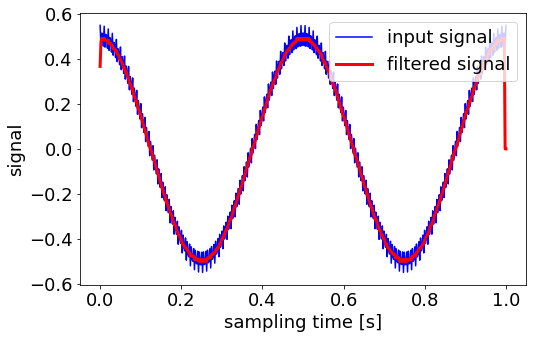

In [14]:
fpga_bin = np.loadtxt('output_signal.txt')
fpga = np.loadtxt('output_signal.txt')/2**7
new = np.concatenate([fpga[2:], np.zeros(2)])
plt.figure(figsize = (8, 5))
plt.plot(sampling, sig, c='blue', label='input signal')
plt.plot(sampling, new, c='red', label='filtered signal', lw = 3)
plt.xlabel('sampling time [s]', fontsize = 18)
plt.ylabel('signal', fontsize = 18)
plt.legend(fontsize = 18)
plt.tick_params(labelsize=18)
plt.show()

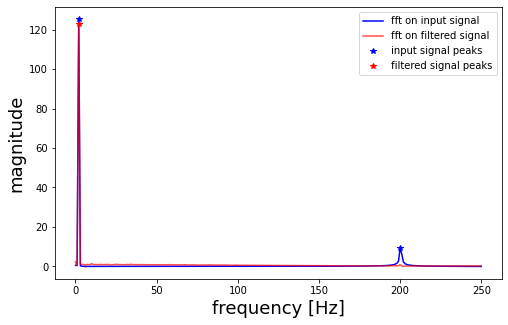

In [15]:
spectrum_filtered = fft.rfft(fpga, nf)
freq_filtered = fft.rfftfreq(nf, d=1/nf)


magnitude = np.abs(spectrum_sampl)
peaks, _ = scipy.signal.find_peaks(magnitude, height=5)

magnitude_filt = np.abs(spectrum_filtered)
peaks_filt, _ = scipy.signal.find_peaks(magnitude_filt, height=5)

plt.figure(figsize = (8, 5))
plt.plot(freq_fourier, np.abs(spectrum_sampl), c='blue', label='fft on input signal')
plt.plot(freq_filtered, np.abs(spectrum_filtered), c='red', label='fft on filtered signal', alpha=0.7)
plt.plot(freq_fourier[peaks], magnitude[peaks], '*', label='input signal peaks', c='blue')
plt.plot(freq_filtered[peaks_filt], magnitude_filt[peaks_filt], '*', label='filtered signal peaks', c='r')
plt.legend(loc='best')
plt.xlabel('frequency [Hz]', fontsize = 18)
plt.ylabel('magnitude', fontsize = 18)
plt.show()

In [16]:
print('input signal frequency analysis')
for i in peaks:
    str0 = f'frequency at which the input signal dispays peaks: {freq_fourier[i]} magnitude {magnitude[i]}'
    print(str0)

print('filtered signal frequency analysis')
for i in peaks_filt:
    str0 = f'frequency at which the filtered signal dispays peaks: {freq_filtered[i]} magnitude {magnitude_filt[i]}'
    print(str0)

input signal frequency analysis
frequency at which the input signal dispays peaks: 2.0 magnitude 125.17183675828915
frequency at which the input signal dispays peaks: 200.0 magnitude 9.48971658018734
filtered signal frequency analysis
frequency at which the filtered signal dispays peaks: 2.0 magnitude 122.82474663564778


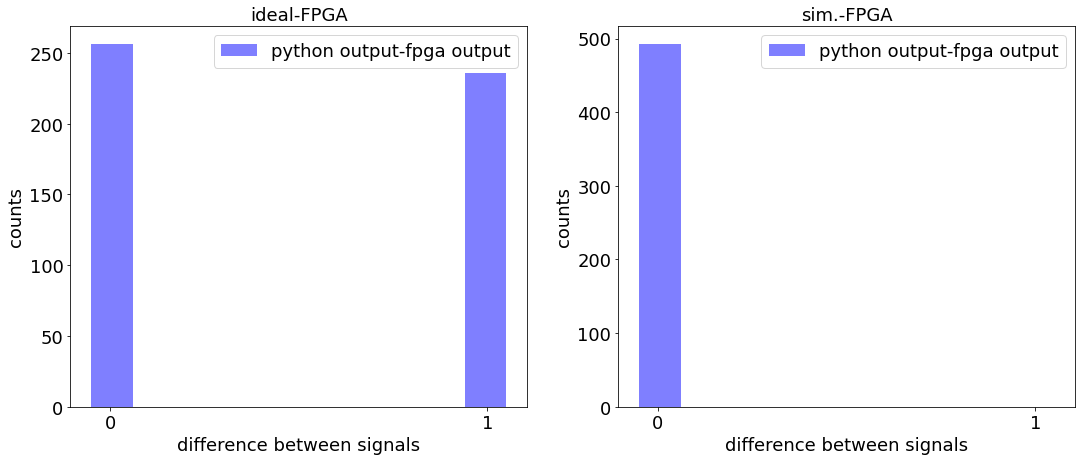

In [17]:
difference_true_fpga = filt_sig_bin[2:-2] - fpga_bin[4:]
difference_sim_fpga = sim_filt_sig[2:-2] - fpga_bin[4:] 

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 7))
ax1.hist(difference_true_fpga[2:-2], range= (-0.05, 1.05),bins=10, color='blue', alpha=0.5, label='python output-fpga output')
ax1.set_xlabel('difference between signals', fontsize = 18)
ax1.legend(fontsize = 18)
ax1.set_ylabel('counts', fontsize = 18)
ax1.tick_params(labelsize=18)
ax1.set_title('ideal-FPGA', fontsize = 18)
ya = ax1.get_xaxis()
ya.set_major_locator(MaxNLocator(integer=True))

ax2.hist(difference_sim_fpga[2:-2], range= (-0.05, 1.05),bins=10, color='blue', alpha=0.5, label='python output-fpga output')
ax2.set_xlabel('difference between signals', fontsize = 18)
ax2.legend(fontsize = 18)
ax2.set_ylabel('counts', fontsize = 18)
ax2.tick_params(labelsize=18)
ax2.set_title('sim.-FPGA', fontsize = 18)
ya = ax2.get_xaxis()
ya.set_major_locator(MaxNLocator(integer=True))

plt.show()